# Locomotive Performance Prediction Model

This notebook builds, trains, and evaluates a machine learning model for predicting locomotive performance and failure risk based on historical data.

## Dataset Overview
The dataset contains locomotive performance metrics including:
- LOCO_TYPE: Locomotive type (1=DE10/NRZ, 2=DE11/Hired)
- LOCO_NUMBER: Locomotive identifier
- YEAR: Year of data
- Availability_Days: Days locomotive was available
- Distance_Travelled: Total distance covered
- Total_Failures: Number of failures
- Reliability: Reliability percentage
- Age_of_Locomotive: Age in years
- Operating_Hours: Total operating hours
- Fleet_Type: NRZ or Hired
- Risk_Score: Calculated risk score
- Reliability_Category: Low/Medium/High reliability

## Model Objective
Predict locomotive performance and failure risk to enable proactive maintenance scheduling.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Data Loading and Exploration


In [2]:
# Load the dataset
df = pd.read_csv('../data/locomotive_ml_dataset.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
df.head()


Dataset Shape: (6680, 20)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6680 entries, 0 to 6679
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LOCO_TYPE              6680 non-null   int64  
 1   LOCO_NUMBER            6680 non-null   int64  
 2   YEAR                   6680 non-null   int64  
 3   Availability_Days      6680 non-null   int64  
 4   Distance_Travelled     6680 non-null   int64  
 5   Distance_per_day       6680 non-null   float64
 6   Total_Failures         6680 non-null   int64  
 7   Reliability            6680 non-null   float64
 8   Failure_Rate           6680 non-null   float64
 9   Age_of_Locomotive      6680 non-null   int64  
 10  Usage_Intensity        6680 non-null   float64
 11  Maintenance_Frequency  6680 non-null   float64
 12  Fuel_Efficiency        6680 non-null   float64
 13  Operating_Hours        6680 non-null   float64
 14  Fleet_Type     

,LOCO_TYPE,LOCO_NUMBER,YEAR,Availability_Days,Distance_Travelled,Distance_per_day,Total_Failures,Reliability,Failure_Rate,Age_of_Locomotive,Usage_Intensity,Maintenance_Frequency,Fuel_Efficiency,Operating_Hours,Fleet_Type,Efficiency_Score,Maintenance_Score,Risk_Score,Reliability_Category,Age_Category
0,1,1016,2017,221,51738,234.11,5,61.79,0.0226,10,1.170543,1.71,1.51,5046.52,NRZ,10.25,5.62,0.2645,Medium,Young
1,1,1020,2018,275,30119,109.52,4,63.80,0.0145,1,0.547618,1.06,1.92,5390.51,NRZ,5.59,31.90,0.0079,Medium,New
2,1,1016,2017,278,37751,135.79,6,69.53,0.0216,2,0.678975,0.97,2.81,5663.91,NRZ,6.67,23.18,0.0293,Medium,New
3,1,2104,2024,121,28364,234.41,5,52.61,0.0413,32,1.172066,1.39,2.27,2610.61,NRZ,10.86,1.59,1.5490,Low,Old
4,2,36383,2021,251,27943,111.33,9,55.74,0.0359,14,0.556633,0.90,2.78,4686.00,Hired,5.96,3.72,0.2798,Low,Mature


In [3]:
# Basic statistics
print("Dataset Statistics:")
df.describe()


Dataset Statistics:


,LOCO_TYPE,LOCO_NUMBER,YEAR,Availability_Days,Distance_Travelled,Distance_per_day,Total_Failures,Reliability,Failure_Rate,Age_of_Locomotive,Usage_Intensity,Maintenance_Frequency,Fuel_Efficiency,Operating_Hours,Efficiency_Score,Maintenance_Score,Risk_Score
count,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000
mean,1.497156,18323.873503,2020.472754,211.409281,41911.530240,199.267611,6.852545,56.068527,0.035555,15.578293,0.996338,1.253241,2.489605,4440.096219,9.517229,6.706743,0.694383
std,0.500029,17218.722175,2.300558,62.678666,18544.798535,63.393297,2.613490,9.878967,0.018040,9.119321,0.316967,0.439805,0.580051,1370.960898,3.142523,8.272443,0.743370
min,1.000000,1002.000000,2017.000000,66.000000,8613.000000,81.740000,1.000000,26.130000,0.003900,1.000000,0.408705,0.500000,1.500000,1361.850000,3.360000,0.750000,0.002300
25%,1.000000,1021.000000,2018.000000,160.000000,28005.750000,147.515000,5.000000,49.207500,0.021500,8.000000,0.737585,0.870000,1.990000,3349.755000,6.970000,2.080000,0.156550
50%,1.000000,2109.000000,2020.000000,210.000000,38579.000000,195.030000,7.000000,56.015000,0.032000,15.000000,0.975150,1.250000,2.475000,4345.510000,9.260000,3.320000,0.446350
75%,2.000000,35635.250000,2022.000000,259.000000,53087.500000,246.855000,9.000000,63.260000,0.047100,23.000000,1.234263,1.640000,2.990000,5458.707500,11.740000,7.052500,0.983825
max,2.000000,37096.000000,2024.000000,357.000000,123526.000000,358.830000,17.000000,84.460000,0.106400,34.000000,1.794143,2.000000,3.500000,8480.410000,19.760000,42.230000,5.936800


In [4]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check data types
print("\nData Types:")
print(df.dtypes)


Missing Values:
LOCO_TYPE                0
LOCO_NUMBER              0
YEAR                     0
Availability_Days        0
Distance_Travelled       0
Distance_per_day         0
Total_Failures           0
Reliability              0
Failure_Rate             0
Age_of_Locomotive        0
Usage_Intensity          0
Maintenance_Frequency    0
Fuel_Efficiency          0
Operating_Hours          0
Fleet_Type               0
Efficiency_Score         0
Maintenance_Score        0
Risk_Score               0
Reliability_Category     0
Age_Category             0
dtype: int64

Data Types:
LOCO_TYPE                  int64
LOCO_NUMBER                int64
YEAR                       int64
Availability_Days          int64
Distance_Travelled         int64
Distance_per_day         float64
Total_Failures             int64
Reliability              float64
Failure_Rate             float64
Age_of_Locomotive          int64
Usage_Intensity          float64
Maintenance_Frequency    float64
Fuel_Efficiency       

In [5]:
# Explore categorical variables
print("Fleet Type Distribution:")
print(df['Fleet_Type'].value_counts())

print("\nReliability Category Distribution:")
print(df['Reliability_Category'].value_counts())

print("\nAge Category Distribution:")
print(df['Age_Category'].value_counts())


Fleet Type Distribution:
Fleet_Type
NRZ      3359
Hired    3321
Name: count, dtype: int64

Reliability Category Distribution:
Reliability_Category
Low         3931
Medium      2365
Critical     361
High          23
Name: count, dtype: int64

Age Category Distribution:
Age_Category
Old       2281
Mature    2133
New       1197
Young     1069
Name: count, dtype: int64


## 2. Data Visualization


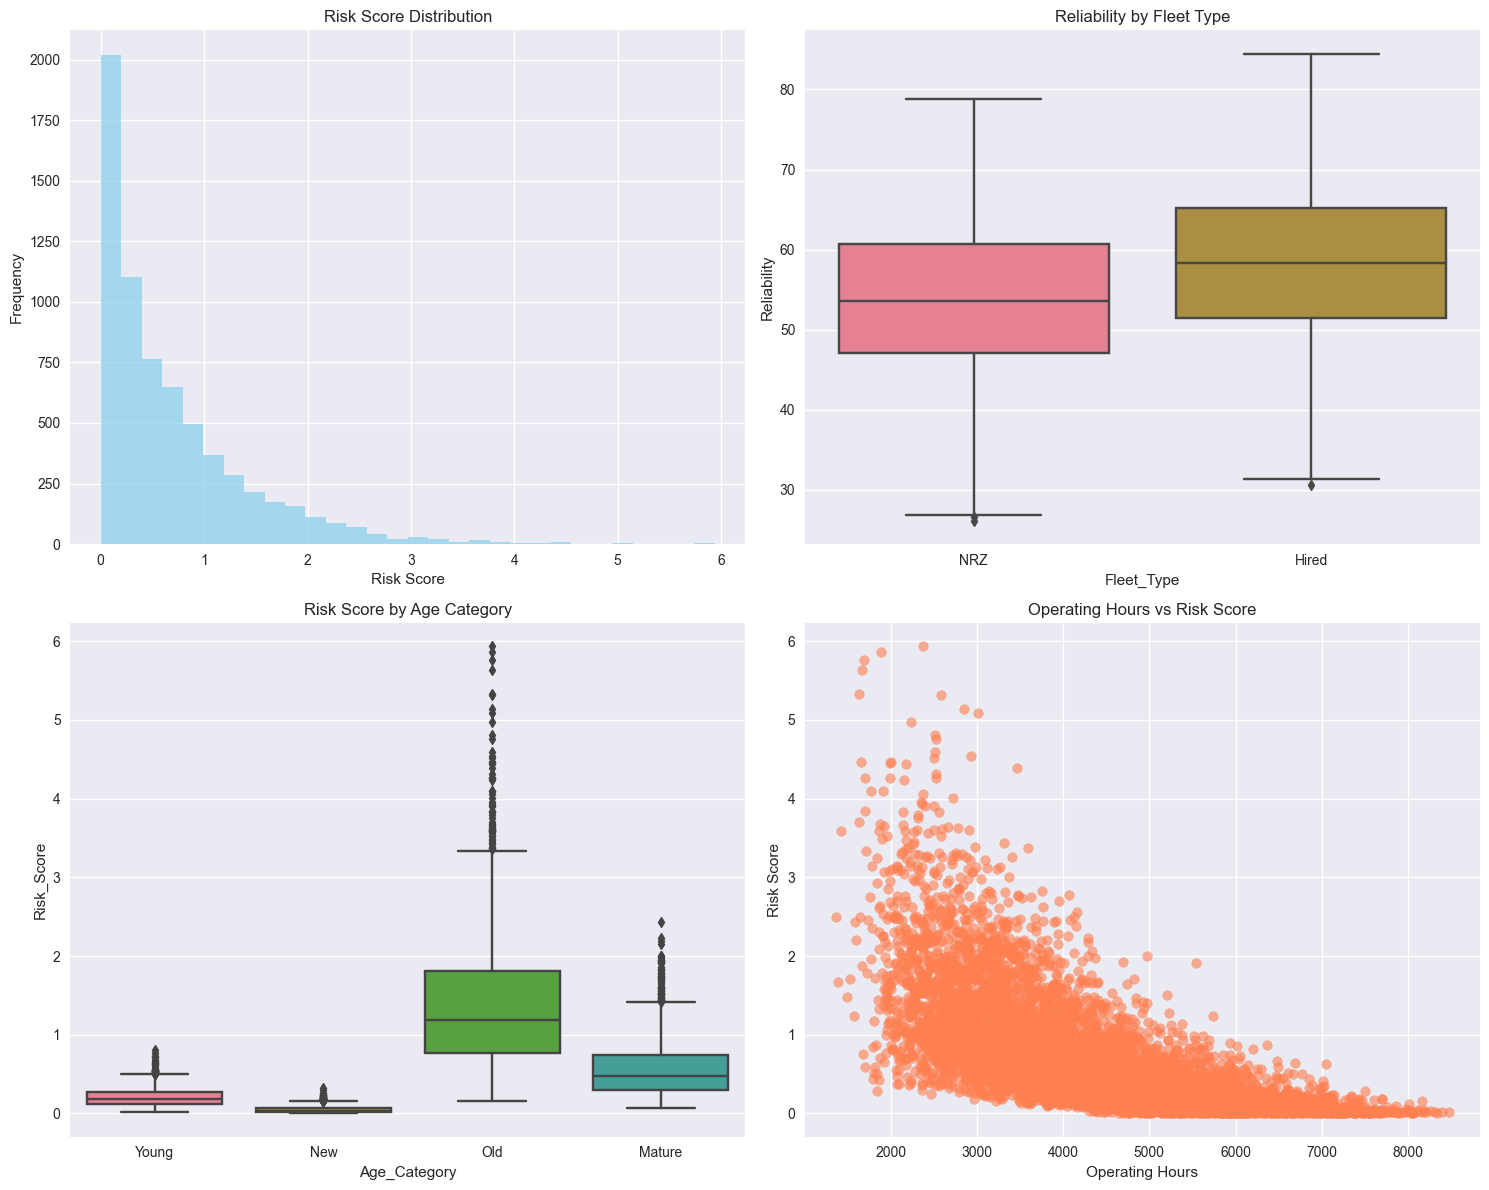

In [6]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Risk Score Distribution
axes[0, 0].hist(df['Risk_Score'], bins=30, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Risk Score Distribution')
axes[0, 0].set_xlabel('Risk Score')
axes[0, 0].set_ylabel('Frequency')

# 2. Reliability by Fleet Type
sns.boxplot(data=df, x='Fleet_Type', y='Reliability', ax=axes[0, 1])
axes[0, 1].set_title('Reliability by Fleet Type')

# 3. Risk Score by Age Category
sns.boxplot(data=df, x='Age_Category', y='Risk_Score', ax=axes[1, 0])
axes[1, 0].set_title('Risk Score by Age Category')

# 4. Operating Hours vs Risk Score
axes[1, 1].scatter(df['Operating_Hours'], df['Risk_Score'], alpha=0.6, color='coral')
axes[1, 1].set_title('Operating Hours vs Risk Score')
axes[1, 1].set_xlabel('Operating Hours')
axes[1, 1].set_ylabel('Risk Score')

plt.tight_layout()
plt.show()


## 3. Feature Engineering and Data Preprocessing


In [7]:
# Create a copy for preprocessing
df_processed = df.copy()

# Encode categorical variables
le_fleet = LabelEncoder()
le_reliability = LabelEncoder()
le_age = LabelEncoder()

df_processed['Fleet_Type_Encoded'] = le_fleet.fit_transform(df_processed['Fleet_Type'])
df_processed['Reliability_Category_Encoded'] = le_reliability.fit_transform(df_processed['Reliability_Category'])
df_processed['Age_Category_Encoded'] = le_age.fit_transform(df_processed['Age_Category'])

# Create additional features
df_processed['Failure_Rate_per_Hour'] = df_processed['Total_Failures'] / (df_processed['Operating_Hours'] + 1)
df_processed['Distance_per_Hour'] = df_processed['Distance_Travelled'] / (df_processed['Operating_Hours'] + 1)
df_processed['Availability_Rate'] = df_processed['Availability_Days'] / 365

print("New features created:")
print("- Failure_Rate_per_Hour")
print("- Distance_per_Hour")
print("- Availability_Rate")
print("- Fleet_Type_Encoded")
print("- Reliability_Category_Encoded")
print("- Age_Category_Encoded")


New features created:
- Failure_Rate_per_Hour
- Distance_per_Hour
- Availability_Rate
- Fleet_Type_Encoded
- Reliability_Category_Encoded
- Age_Category_Encoded


## 4. Model Building - Risk Score Prediction (Regression)


In [8]:
# Prepare features for risk score prediction
feature_columns = [
    'LOCO_TYPE', 'YEAR', 'Availability_Days', 'Distance_Travelled', 
    'Distance_per_day', 'Total_Failures', 'Reliability', 'Failure_Rate',
    'Age_of_Locomotive', 'Usage_Intensity', 'Maintenance_Frequency', 
    'Fuel_Efficiency', 'Operating_Hours', 'Fleet_Type_Encoded',
    'Efficiency_Score', 'Maintenance_Score', 'Reliability_Category_Encoded',
    'Age_Category_Encoded', 'Failure_Rate_per_Hour', 'Distance_per_Hour', 'Availability_Rate'
]

X = df_processed[feature_columns]
y_risk = df_processed['Risk_Score']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y_risk.shape}")
print(f"\nFeature columns: {len(feature_columns)}")


Features shape: (6680, 21)
Target shape: (6680,)

Feature columns: 21


In [9]:
# Split data for risk score prediction
X_train, X_test, y_train, y_test = train_test_split(X, y_risk, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 5344
Test set size: 1336


In [10]:
# Train Random Forest Regressor for Risk Score
rf_risk = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_risk.fit(X_train, y_train)

# Make predictions
y_pred_risk = rf_risk.predict(X_test)

# Evaluate model
mse_risk = mean_squared_error(y_test, y_pred_risk)
r2_risk = r2_score(y_test, y_pred_risk)

print("Risk Score Prediction Results:")
print(f"Mean Squared Error: {mse_risk:.4f}")
print(f"R² Score: {r2_risk:.4f}")
print(f"RMSE: {np.sqrt(mse_risk):.4f}")

# Cross-validation
cv_scores = cross_val_score(rf_risk, X, y_risk, cv=5, scoring='r2')
print(f"\nCross-validation R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Risk Score Prediction Results:
Mean Squared Error: 0.0034
R² Score: 0.9944
RMSE: 0.0583

Cross-validation R² scores: [0.99299496 0.99307965 0.99061774 0.99332329 0.99329315]
Mean CV R²: 0.9927 (+/- 0.0021)


## 5. Model Building - Reliability Category Prediction (Classification)


In [11]:
# Prepare data for reliability category prediction
y_reliability = df_processed['Reliability_Category_Encoded']

# Split data
X_train_rel, X_test_rel, y_train_rel, y_test_rel = train_test_split(
    X, y_reliability, test_size=0.2, random_state=42, stratify=y_reliability
)

# Train Random Forest Classifier for Reliability Category
rf_reliability = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_reliability.fit(X_train_rel, y_train_rel)

# Make predictions
y_pred_reliability = rf_reliability.predict(X_test_rel)

# Evaluate model
accuracy_rel = accuracy_score(y_test_rel, y_pred_reliability)

print("Reliability Category Prediction Results:")
print(f"Accuracy: {accuracy_rel:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_rel, y_pred_reliability, 
                          target_names=le_reliability.classes_))

# Cross-validation
cv_scores_rel = cross_val_score(rf_reliability, X, y_reliability, cv=5, scoring='accuracy')
print(f"\nCross-validation Accuracy scores: {cv_scores_rel}")
print(f"Mean CV Accuracy: {cv_scores_rel.mean():.4f} (+/- {cv_scores_rel.std() * 2:.4f})")


Reliability Category Prediction Results:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    Critical       1.00      1.00      1.00        72
        High       1.00      1.00      1.00         5
         Low       1.00      1.00      1.00       786
      Medium       1.00      1.00      1.00       473

    accuracy                           1.00      1336
   macro avg       1.00      1.00      1.00      1336
weighted avg       1.00      1.00      1.00      1336


Cross-validation Accuracy scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0000 (+/- 0.0000)


## 6. Feature Importance Analysis


Top 10 Most Important Features for Risk Prediction:
                  feature  importance
7            Failure_Rate    0.725101
15      Maintenance_Score    0.123287
9         Usage_Intensity    0.047115
4        Distance_per_day    0.046087
8       Age_of_Locomotive    0.041049
19      Distance_per_Hour    0.004761
18  Failure_Rate_per_Hour    0.004003
14       Efficiency_Score    0.001891
2       Availability_Days    0.001098
17   Age_Category_Encoded    0.001013


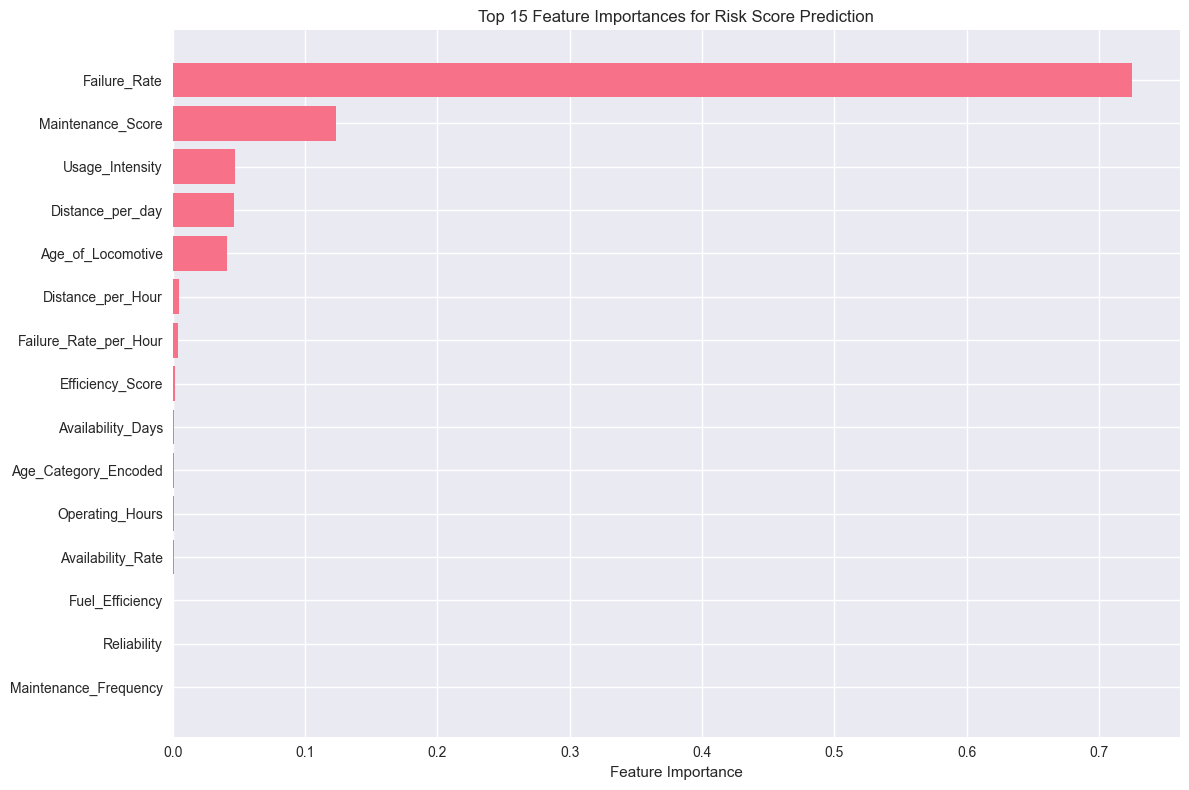

In [12]:
# Get feature importance for risk prediction
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_risk.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features for Risk Prediction:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances for Risk Score Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 7. Model Deployment Preparation


In [13]:
# Save the trained models and preprocessing objects
import os

# Create models directory if it doesn't exist
models_dir = '../app/ml_models'
os.makedirs(models_dir, exist_ok=True)

# Save models
joblib.dump(rf_risk, os.path.join(models_dir, 'risk_score_model.pkl'))
joblib.dump(rf_reliability, os.path.join(models_dir, 'reliability_model.pkl'))
joblib.dump(scaler, os.path.join(models_dir, 'scaler.pkl'))

# Save label encoders
joblib.dump(le_fleet, os.path.join(models_dir, 'fleet_encoder.pkl'))
joblib.dump(le_reliability, os.path.join(models_dir, 'reliability_encoder.pkl'))
joblib.dump(le_age, os.path.join(models_dir, 'age_encoder.pkl'))

# Save feature columns for later use
joblib.dump(feature_columns, os.path.join(models_dir, 'feature_columns.pkl'))

print("Models and preprocessing objects saved successfully!")
print("Files saved:")
print(f"- {models_dir}/risk_score_model.pkl")
print(f"- {models_dir}/reliability_model.pkl")
print(f"- {models_dir}/scaler.pkl")
print(f"- {models_dir}/fleet_encoder.pkl")
print(f"- {models_dir}/reliability_encoder.pkl")
print(f"- {models_dir}/age_encoder.pkl")
print(f"- {models_dir}/feature_columns.pkl")


Models and preprocessing objects saved successfully!
Files saved:
- ../app/ml_models/risk_score_model.pkl
- ../app/ml_models/reliability_model.pkl
- ../app/ml_models/scaler.pkl
- ../app/ml_models/fleet_encoder.pkl
- ../app/ml_models/reliability_encoder.pkl
- ../app/ml_models/age_encoder.pkl
- ../app/ml_models/feature_columns.pkl


## 8. Model Summary and Next Steps


In [14]:
print("=" * 60)
print("LOCOMOTIVE PERFORMANCE PREDICTION MODEL SUMMARY")
print("=" * 60)

print(f"\nDataset Information:")
print(f"- Total Records: {len(df):,}")
print(f"- Features Used: {len(feature_columns)}")
print(f"- Fleet Types: {df['Fleet_Type'].nunique()} ({', '.join(df['Fleet_Type'].unique())})")
print(f"- Locomotive Types: {df['LOCO_TYPE'].nunique()}")

print(f"\nModel Performance:")
print(f"- Risk Score Prediction R²: {r2_risk:.4f}")
print(f"- Risk Score Prediction RMSE: {np.sqrt(mse_risk):.4f}")
print(f"- Reliability Category Accuracy: {accuracy_rel:.4f}")

print(f"\nTop 5 Important Features:")
for i, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    print(f"{i}. {row['feature']}: {row['importance']:.4f}")

print(f"\nModels Ready for Deployment:")
print(f"✓ Risk Score Prediction Model")
print(f"✓ Reliability Category Prediction Model")
print(f"✓ Preprocessing Pipeline")
print(f"✓ Label Encoders")

print(f"\nNext Steps:")
print(f"1. Integrate models into Flask application")
print(f"2. Create prediction API endpoints")
print(f"3. Update locomotive management interface")
print(f"4. Test end-to-end prediction workflow")

print("\n" + "=" * 60)


LOCOMOTIVE PERFORMANCE PREDICTION MODEL SUMMARY

Dataset Information:
- Total Records: 6,680
- Features Used: 21
- Fleet Types: 2 (NRZ, Hired)
- Locomotive Types: 2

Model Performance:
- Risk Score Prediction R²: 0.9944
- Risk Score Prediction RMSE: 0.0583
- Reliability Category Accuracy: 1.0000

Top 5 Important Features:
1. Failure_Rate: 0.7251
2. Maintenance_Score: 0.1233
3. Usage_Intensity: 0.0471
4. Distance_per_day: 0.0461
5. Age_of_Locomotive: 0.0410

Models Ready for Deployment:
✓ Risk Score Prediction Model
✓ Reliability Category Prediction Model
✓ Preprocessing Pipeline
✓ Label Encoders

Next Steps:
1. Integrate models into Flask application
2. Create prediction API endpoints
3. Update locomotive management interface
4. Test end-to-end prediction workflow

